# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6269,1095,1980,3860,609,2162
1,11594,7779,12144,3252,8035,3029
2,16225,1825,1765,853,170,1067


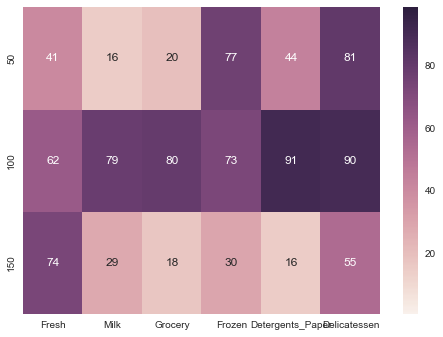

In [3]:
# Select three indices of your choice you wish to sample from the dataset
### UPDATED FROM PREVIOUS REVIEW FEEDBACK: I updated to better choose points that are different from each other
indices = [50, 100, 150]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)


### FROM PREVIOUS REVIEW FEEDBACK
### To help me compare the values to the mean instead of eyeballing loosely

# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns

# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)

# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)

# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]

# Now, create the heat map using the seaborn library
_ = sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

The second store seems to buy a lot of everything relative to the mean. Their purchase is above average in each of the categories, and hence I think they may be something like a grocery store or a market; some place which sells these items in one place.

The third store buys a lot of fresh and delicatessen, but not so much of the other things (relative to the mean). That tells me they are probably a cafe. Their milk purchase is reasonable for a small establishment.

The first store buys a lot of Delicatessen and Frozen items, a decent amount of Fresh (close to the mean) and a decent amount of Detergents_Paper. They maybe a market specializing in pastries, or again a small cafe.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [4]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
X = data.copy()
X.drop(['Grocery'], axis = 1, inplace = True)
y = data[['Grocery']]

# Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
y_pred = regressor.predict(X_test)

from sklearn.metrics import r2_score
score=r2_score(y_test, y_pred)
print "R^2 value obtained was: " + str(score)


R^2 value obtained was: 0.620414784788


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

I chose to predict Grocery, because well...actually I tried Milk first and got a negative R^2 value, which meant it wasn't related to the rest of the data. So I wanted to find a feature that would be relevant for this question, so I looked at the scatter plots below and it looked as if grocery purchases had some correlation with the other variables.

Based on the review feedback, if Grocery has a high correlation with the other variables, it indicates that the value of grocery can in fact, be predicted using the other variables. This means that any effect it has on categorization can be modeled using the other variables that we have and so, we would not have (too much :) ) trouble if we just excluded it from algorithm. 

Milk, on the other hand, with it's negative R^2 score, would be important to include, since excluding it would mean excluding information about the customers that is not available through the other variables.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

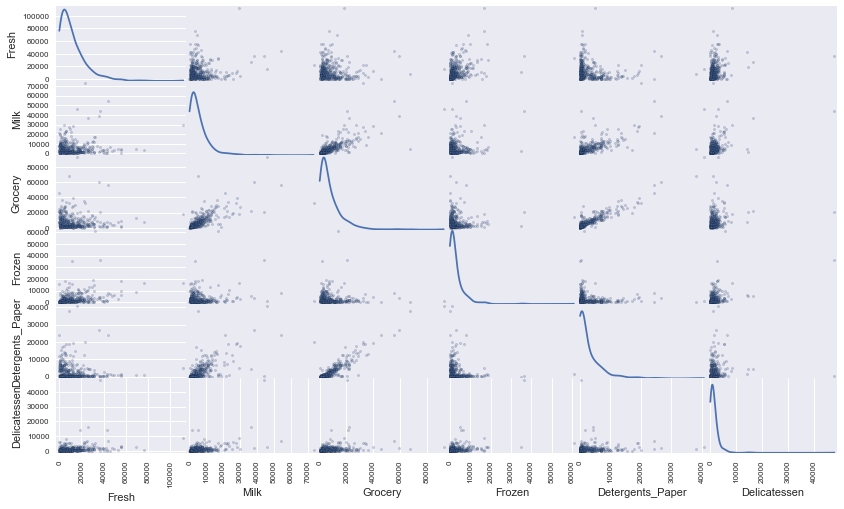

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

Yes, there are some features that exhibit some degree of correlation. For example:

1. Detergent and Grocery
2. Milk and Grocery

The data for these pairs seem to lie on or close to a line. This observations seems to agree with the analysis in the previous question, that gave Grocery a Positive R^2 value. In fact, it seems like the amount of milk and Detergent_Paper is a good start to being able to predict the grocery purchase of a customer.

The data for these variables is highly skewed toward lower values, i.e. there are some customers ordering a lot, but the majority of customers order close to the median (which would be much higher than the mean for all these values), rather than the mean.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

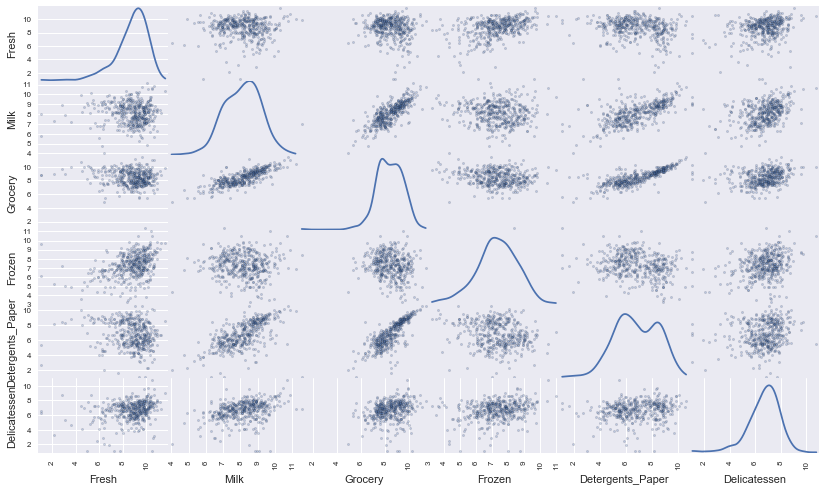

In [6]:
# TODO: Scale the data using the natural logarithm
log_data = data.copy()
log_data = np.log(log_data)

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.copy()
log_samples = np.log(log_samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [7]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.743372,6.998510,7.590852,8.258422,6.411818,7.678789
1,9.358243,8.959183,9.404590,8.087025,8.991562,8.015988
2,9.694309,7.509335,7.475906,6.748760,5.135798,6.972606


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [8]:
# For each feature find the data points with extreme high or low values
outliers = []
all_outliers=[]
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
        
    # Display the outliers
#     print "Data points considered outliers for the feature '{}':".format(feature)
#     display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # Catch the outliers
    outlier_points = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    all_outliers = np.append(all_outliers, outlier_points.index.values.astype('int64'))
    
# GOT THESE LINES FROM THE PREVIOUS REVIEW. They're pretty cool.
# Count the unique elements in the all_outliers array
all_outlier, indices = np.unique(all_outliers, return_inverse=True)
counts = np.bincount(indices)

# Obtain outliers using the counts
outliers = all_outlier[counts>1].astype(int)
print "The outliers are: " + str(outliers)

good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

The outliers are: [ 65  66  75 128 154]


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

There are only five points that appeared on multiple features as outliers. While it would make sense on some level to remove all the outliers corresponding to even one feature, I decided to stick to only the ones that are considered outliers for more than one features, because the list above is pretty long, and it might affect the performance of the algorithm if I strictly remove all outliers.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

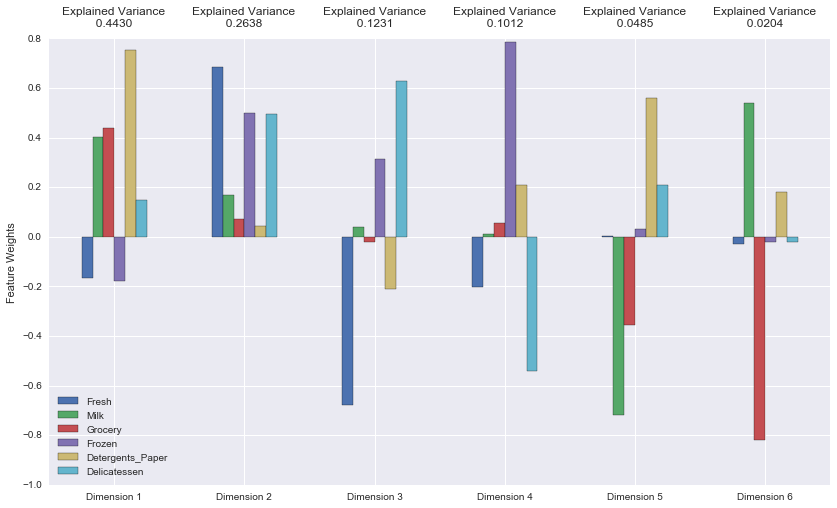

In [9]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
 
pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

From the below code snippet, it is easy to see that the **first two** principal components account for about 70% of the total variance, and the **first four** cover 93 % of the variance .Considering these numbers, and the minor advantage of adding the fifth and sixth dimensions, it might make sense to restrict the PCA dimensions to four, or even to two since most of the variance is captured by these two dimensions.

Some interpretations of the first 4 dimensions is included here. If PCA is working as it should (and it should be working as it should), the four principal components will represent the four directions of maximum variance in the data. If you are in a sea of this data, and are heading along one of these dimensions, you are walking on a path that will show you customers with a particular kind of variation. Each of these dimensions, thus could be said to representative of four different kinds of customer spending.

The first dimension, with low (negative) weights on Fresh and Frozen, but reasonably high weights on everything else, could be said to be representative of a retail store.

The second dimension could be a restaurant since it has high weights on Fresh, Frozen and Delicatessen, all of which can be used to prepare mediocre food.

The third dimension has a great weight on Delicatessen and Frozen. I'm not sure what this could be..maybe a bakery or a fancy Patisserie.

The fourth dimension has high weights Frozen and Detergents. I can't think of any kind of business that would by detergents and delicatessen, but not much of anything else. Maybe a butcher shop with lots of frozen meat?

In [10]:
print pca_results['Explained Variance'].cumsum()

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-1.1404,0.6710,0.9823,0.0603,1.1423,-0.0055
1,2.3579,1.7393,0.2210,0.2840,0.5939,0.0148
2,-1.9406,0.2418,-0.2884,-1.2041,-0.0917,0.1492


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

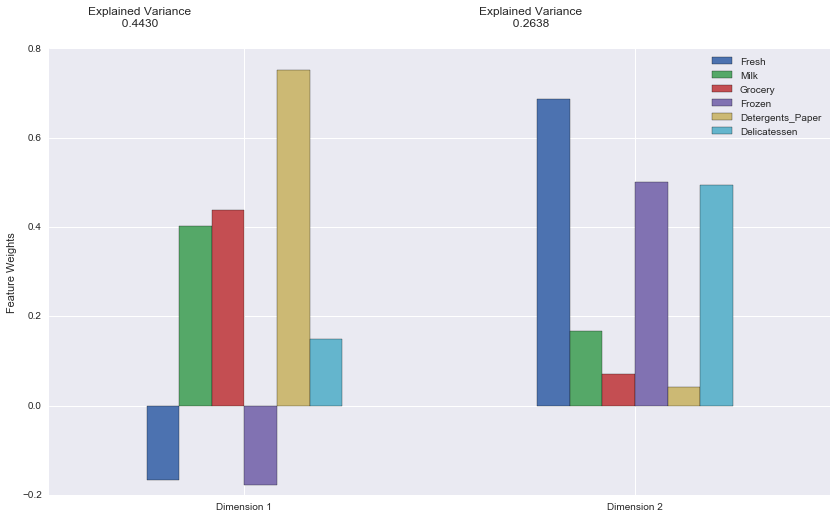

In [18]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
 
pca = PCA(n_components=2)
pca.fit(good_data)

reduced_data = pca.transform(good_data)
# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-1.1404,0.6710
1,2.3579,1.7393
2,-1.9406,0.2418


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

KMeans assumes that every point lies in a cluster. GMM assumes that each point has a probability of lying in a cluster.

The main advantage of K-Means is increased speed. However, the algorithm does make the assumption of hard clusters, which means points can't be graded on a threshold which we can later set based on testing data.

The main advantage of GMM is that it performs soft-clustering. So, for each point, we get a probability of it lying in a cluster, and so we can get a better idea for points lying close to the boundary. The main disadvantage is speed since GMM has to perform more computations.

I tried both GMM and K-Means, however decided to go with K-Means. GMM is a better choice here since the the distribution of spending is continuous and hence, it may be better for us to get a probabilistic score for each point. However, I wanted to analyze the effect that this "wrong" choice would make on the data, hence decided to go with K-Means. Also, K-Means is faster!

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [22]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster(n_clus):
    clusterer = KMeans(n_clusters = n_clus)

    # TODO: Predict the cluster for each data point
    clusterer.fit(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_
    labels = clusterer.labels_
    preds = clusterer.predict(reduced_data)

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)
    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    
    print "Score for " + str(n_clus) + " clusters: " + str(score)
    
    return clusterer

for n_clus in range(2,20):
    cluster(n_clus)

clusterer = KMeans(2)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
sample_preds = clusterer.predict(pca_samples)
centers = clusterer.cluster_centers_
labels = clusterer.labels_
score = silhouette_score(reduced_data, preds)


Score for 2 clusters: 0.426281015469
Score for 3 clusters: 0.397138208845
Score for 4 clusters: 0.33404916202
Score for 5 clusters: 0.350396046541
Score for 6 clusters: 0.355061632058
Score for 7 clusters: 0.364495201493
Score for 8 clusters: 0.365704703069
Score for 9 clusters: 0.339418377606
Score for 10 clusters: 0.3685234169
Score for 11 clusters: 0.339586621648
Score for 12 clusters: 0.359569872841
Score for 13 clusters: 0.342579645169
Score for 14 clusters: 0.353844268908
Score for 15 clusters: 0.360596834307
Score for 16 clusters: 0.3639638794
Score for 17 clusters: 0.352956642374
Score for 18 clusters: 0.35990913445
Score for 19 clusters: 0.349252528604


### Question 7

*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 


**Answer:**

I have listed the silhoutte score for cluster sizes ranging from 2 to 19 above. The best silhouette score is obtained when we have only two clusters, which suggests that the customers can be divided roughly into two segments.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

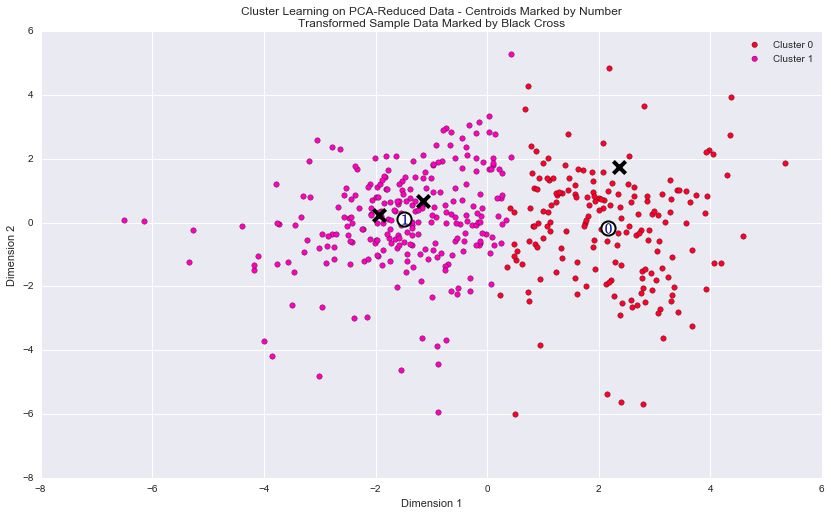

In [23]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [24]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
Segment 1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

I used the code I was given in the review feedback to provide bar graphs, so I could interpret the information better.

Segment 0 buys a lot of milk and grocery and paper relative to the mean, which might mean they are a store, probably a small one since they buy less fresh stuff than what I suspected to be hotels above.

Segment 1 could be a cafe, or maybe a small restaurant, or maybe even a big restaurant since I don't have a feel for this intra-separation for these numbers. I am basing my answer on the fact that they make a lot of purchases in the fresh category relative to the mean and lower than the mean for all other categories.


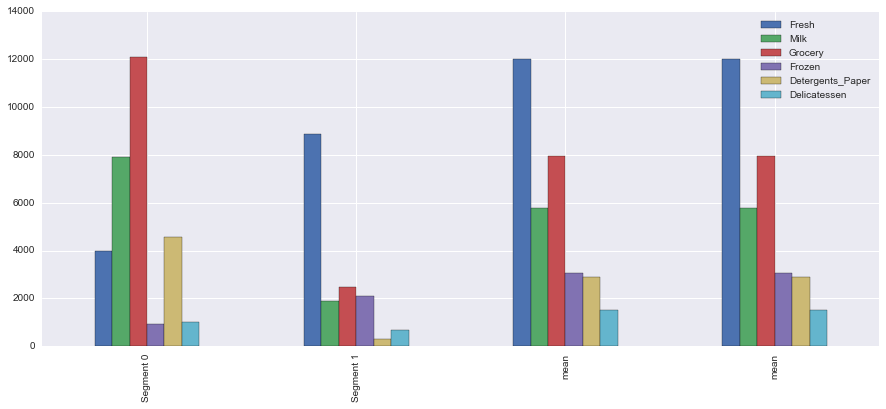

In [26]:
# Import Seaborn, a very powerful library for Data Visualisation
# FROM REVIEW FEEDBACK
import seaborn as sns
true_centers = true_centers.append(data.describe().loc['mean'])
_ = true_centers.plot(kind='bar', figsize=(15,6))

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [27]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:**

My original answers were as follows:

*The second store seems to buy a lot of everything relative to the mean. Their purchase is above average in each of the categories, and hence I think they may be something like a grocery store or a market; some place which sells these items in one place.
The third store buys a lot of fresh and delicatessen, but not so much of the other things (relative to the mean). That tells me they are probably a cafe. Their milk purchase is reasonable for a small establishment.
The first store buys a lot of Delicatessen and Frozen items, a decent amount of Fresh (close to the mean) and a decent amount of Detergents_Paper. They maybe a market specializing in pastries, or again a small cafe.*

I think the clustering does a good job of predicting the points given the values. In fact, from the above answers, the answers it provides agrees with mine. 

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**

The change might be a good idea for customers who do not need Fresh or Dairy data. The problem is that if delivery goes down to 3 days a week, the fresh and dairy products might get spoilt, or at least not look so fresh on the days that delivery is not happening.

So, if our distributor wanted to conduct an A/B test, he could target the stores first. Based on our clustering algorithm, we would choose points in Cluster 0, randomly splitting them so that some of them get the 3-day treatment and some of them get the 5-day treatment. This would show our distributor if the test affects the retention of customers in this cluster.

He could run this test independently for the customers in Cluster 1, and this would let him know if the customers in this cluster (which we suspect to be restaurants) would be okay with getting the 3-day treatment. 

Based on the results of this experiment, we can proceed.


### Question 11
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the clustering data you've found to assist a supervised learning analysis?*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:**

For supervised learning, we need a label, so we need to extract some information from the clusters to use as a feature. 

One such feature could be the cluster assignment itself. The cluster assignment is adding information to our feature space in the way of what we think (from all our analysis above). So this could be a really useful feature in predicting things about the customers, and the distributor can be happier about thinking they are making a more informed decision.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

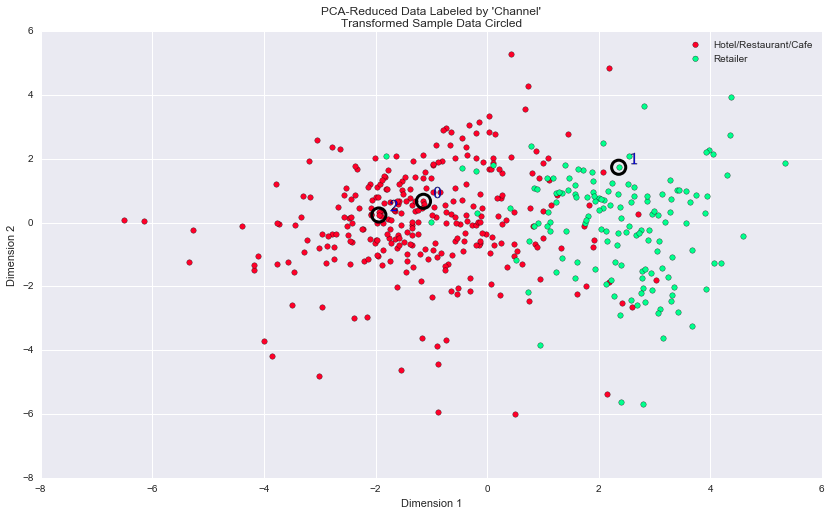

In [28]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

I am actually very impressed with the performance of the KMeans algorithm. There are some outliers that are not captured by the algorithm, but I guess that is to be expected. There are some customers that *could* be classified as purely Retailers and/or Hotels or cafes, because the division captured by our algorithm is pretty close to what is predicted by the Channel above.

The classifications are consistent with what I had thought after the clustering algorithm had run.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.